<a href="https://colab.research.google.com/github/Shelly10-10/flood_prediction/blob/main/disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#Read the dataset
import pandas as pd
import numpy as np

df = pd.read_csv("improved_flood_dataset.csv")

print(df.shape)
print(df.columns)
print(df['Flood_Reported'].value_counts())


(10000, 19)
Index(['Region', 'Latitude', 'Longitude', 'Date', 'Rainfall_mm',
       'Tide_Level_m', 'Soil_Saturation_%', 'River_Level_m',
       'Land_Elevation_m', 'Distance_to_Coast_km', 'Cyclone_Alert',
       'Temperature_C', 'Humidity_%', 'Wind_Speed_kmph', 'Evaporation_mm',
       'Satellite_Cloud_Index', 'Infrastructure_Grade', 'Flood_Risk_Score',
       'Flood_Reported'],
      dtype='object')
Flood_Reported
0    7136
1    2864
Name: count, dtype: int64


In [4]:
#Dropping the target column
# Date processing
from sklearn.metrics import confusion_matrix

grade_mapping = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':0
}
df['Infrastructure_Grade'] = df['Infrastructure_Grade'].map(grade_mapping)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Target
y = df['Flood_Reported']

# Features
drop_cols = [
    'Flood_Reported',
    'Flood_Risk_Score',
    'Region',
    'Date'
]

X = df.drop(columns=drop_cols)



In [5]:
#Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [6]:
#Handling missing value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)


In [7]:
#Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)


In [8]:
#Model implementation
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_imp, y_train)
#Evaluation report of random forest
from sklearn.metrics import classification_report

y_pred_rf = rf_model.predict(X_test_imp)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1427
           1       0.93      0.92      0.92       573

    accuracy                           0.96      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.96      0.96      0.96      2000



 99%|===================| 3976/4000 [02:38<00:00]       

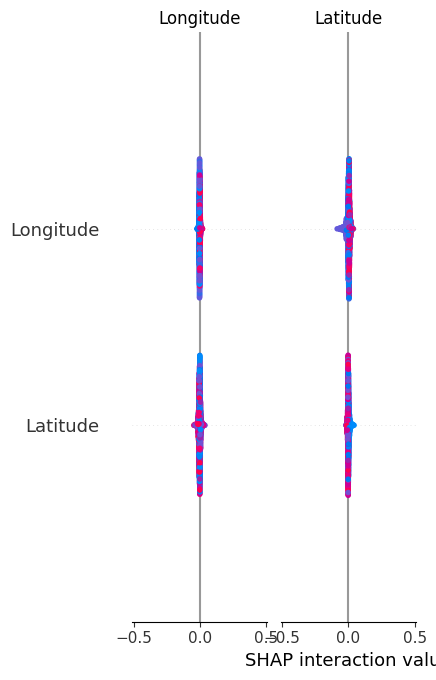

In [11]:
import shap
import pandas as pd
X_train_imp_df = pd.DataFrame(
    X_train_imp,
    columns=X.columns,
    index=X_train.index
)

X_test_imp_df = pd.DataFrame(
    X_test_imp,
    columns=X.columns,
    index=X_test.index
)

explainer_rf = shap.Explainer(
    rf_model,
    X_train_imp_df
)

shap_values_rf = explainer_rf(X_test_imp_df)
shap_values_rf.values.shape == X_test_imp_df.shape
shap.summary_plot(
    shap_values_rf,
    X_test_imp_df
)

